In [1]:
from codinglab import PrefixCodeTree, TreeNode, PrefixEncoderDecoder

# typing:
from codinglab import SourceChar, ChannelChar
from typing import Sequence, Optional, Dict, List
from dataclasses import dataclass
from enum import Enum

## Задача 0: Первое знакомство

Итак, что умеет пакет, который мы только что импортировали?

Для нас в первую очередь интереснен класс ``PrefixEncoderDecoder``; Если от него должны образом отнаследоваться он за нас будет уметь строить и декодировать префиксные коды для сообщений

```python

class PrefixEncoderDecoder(
    Encoder[SourceChar, ChannelChar], Decoder[SourceChar, ChannelChar], ABC
):
    """
    Abstract base class for prefix code encoder-decoders.

    This class implements the common functionality for prefix codes,
    including encoding, decoding, and maintaining both a code table
    and a decoding tree. Concrete implementations must define how to
    build the prefix code tree based on their specific algorithm.

    Attributes:
        _source_alphabet: Alphabet of source symbols to encode
        _channel_alphabet: Alphabet of channel symbols for encoding
        _code_table: Mapping from source symbols to their code sequences
        _tree: Prefix code tree used for decoding
    """

    def __init__(
        self,
        source_alphabet: Sequence[SourceChar],
        channel_alphabet: Sequence[ChannelChar],
    ) -> None:
        ...
    def encode(self, message: Sequence[SourceChar]) -> Sequence[ChannelChar]:
        ...
    def decode(self, encoded: Sequence[ChannelChar]) -> Sequence[SourceChar]:
        ...
    @abstractmethod
    def _build_prefix_code_tree(self) -> None:
        ...
    @property
    def code_table(self) -> Optional[Dict[SourceChar, Sequence[ChannelChar]]]:
       ...
    @property
    def tree(self) -> Optional[PrefixCodeTree[ChannelChar, SourceChar]]:
        ...
    @property
    def source_alphabet(self) -> Sequence[SourceChar]:
        ...
    @property
    def channel_alphabet(self) -> Sequence[ChannelChar]:
        ...
```

Построение деревьев для кодов осуществляется через простенький класс:

```python

@dataclass
class TreeNode(Generic[ChannelChar, SourceChar]):
    value: Optional[SourceChar] = None
    children: Dict[ChannelChar, TreeNode[ChannelChar, SourceChar]] = field(
        default_factory=dict
    )

    def leaf(self) -> bool:
        ...
        

class PrefixCodeTree(Generic[ChannelChar, SourceChar]):
    """
    Prefix code tree for efficient decoding.

    This tree data structure enables decoding of prefix codes by
    traversing from the root to leaves based on the input sequence.
    Each leaf corresponds to a source symbol, and the path from root
    to leaf defines the code for that symbol.

    Attributes:
        root: Root node of the prefix code tree
    """

    def __init__(
        self, root: Optional[TreeNode[ChannelChar, SourceChar]] = None
    ) -> None:
        """
        Initialize a prefix code tree.

        Args:
            root: Optional root node for the tree. If None, creates
                  a new empty root node.
        """
        self.root = TreeNode() if root is None else root
        """Root node of the prefix code tree."""

    def insert_code(self, code: List[ChannelChar], symbol: SourceChar) -> None:
        """
        Insert a code sequence into the tree.

        This method builds the tree by adding a path from the root
        corresponding to the code sequence, ending with a leaf node
        containing the source symbol.

        Args:
            code: Sequence of channel symbols representing the code
            symbol: Source symbol that this code represents

        Raises:
            ValueError: If the code conflicts with existing codes
                       (violates prefix property)
        """
        ...
    def decode(
        self, sequence: List[ChannelChar], position: int = 0
    ) -> Tuple[Optional[SourceChar], int]:
        ...

    def vizualize(self) -> Digraph:
        ...
```

Для примера - глупый кодировщик, который кодирует все символы алфавита источника кодами одинаковой длинны:

In [2]:
class DummyEncoder(PrefixEncoderDecoder[SourceChar, ChannelChar]):
    """
    Fixed-length prefix encoder-decoder.

    This encoder assigns fixed-length codes to source symbols by
    enumerating all possible code sequences of a given length in
    lexicographic order. All codes have the same length, making
    it inefficient for non-uniform symbol distributions but
    simple to implement and understand.

    Attributes:
        _code_length: Fixed length of all code sequences
    """

    def __init__(
        self,
        source_alphabet: Sequence[SourceChar],
        channel_alphabet: Sequence[ChannelChar],
        code_length: int = 1,
    ) -> None:
        """
        Initialize the dummy encoder with fixed code length.

        Args:
            source_alphabet: Sequence of source symbols to encode
            channel_alphabet: Sequence of channel symbols for encoding
            code_length: Fixed length of all code sequences (default: 1)

        Raises:
            ValueError: If code_length is not positive, or if there
                       aren't enough unique codes for all source symbols
        """
        self._code_length = code_length
        """Fixed length of all code sequences."""
        super().__init__(source_alphabet, channel_alphabet)

    def _build_prefix_code_tree(self) -> None:
        """
        Build a prefix code tree with fixed-length codes.

        This method constructs a prefix code tree where each source
        symbol gets a code of exactly _code_length channel symbols.
        Codes are assigned in lexicographic order based on the
        enumeration of all possible code sequences.

        Raises:
            ValueError: If code_length is not positive, or if the
                       channel alphabet doesn't provide enough unique
                       codes for all source symbols
        """
        if self._code_length <= 0:
            raise ValueError(f"Code length must be positive, got {self._code_length}")

        # Calculate maximum number of unique codes available
        max_unique_codes = len(self._channel_alphabet) ** self._code_length
        if max_unique_codes < len(self._source_alphabet):
            raise ValueError(
                f"Cannot encode {len(self._source_alphabet)} symbols with "
                f"code length {self._code_length} and alphabet size "
                f"{len(self._channel_alphabet)} (maximum unique codes: {max_unique_codes})"
            )

        # Build the tree directly
        self._tree = PrefixCodeTree()
        channel_len = len(self._channel_alphabet)
        for i, symbol in enumerate(self._source_alphabet):
            # Generate code for symbol using base-channel_len representation
            code = []
            temp_i = i

            # Convert index i to base-(channel_len) representation
            for _ in range(self._code_length):
                code.append(self._channel_alphabet[temp_i % channel_len])
                temp_i //= channel_len

            # Reverse the code because we generated from least significant digit
            reversed_code = list(reversed(code))

            # Insert code into tree
            self._tree.insert_code(reversed_code, symbol)

Что можем сделать с таким кодировщиком? 

Для начала можно попробовать взять что-нибудь закодировать и нарисовать наш код в виде дерева:

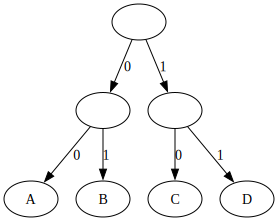

In [3]:
enc = DummyEncoder(["A", "B", "C", "D"], ["0", "1"], 2)
enc.tree.vizualize()

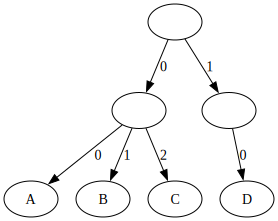

In [4]:
enc = DummyEncoder(["A", "B", "C", "D"], ["0", "1", "2"], 2)
enc.tree.vizualize()

In [5]:
message = "ABDBD"
encoded = enc.encode(list(message))
decoded = enc.decode(encoded)
decoded_str = "".join(decoded)

print(f"   Encoded: {''.join(encoded)}")
print(f"   Decoded: '{decoded_str}'")
print(f"   Match: {message == decoded_str}")

   Encoded: 0001100110
   Decoded: 'ABDBD'
   Match: True


Можно запустить эксперимент (хотя пока у нас все условия идеальные смысла в этом немного; а вот если канал умеет "портить" данные...)

In [6]:
from codinglab import (
    FixedMessagesSender,
    ProbabilisticSender,
    NoiselessChannel,
    TrackingReceiver,
    ExperimentRunner,
)
from codinglab import PandasLogger

In [7]:
# Prepare messages
messages = ["hello", "world", "test", "message"]

logger = PandasLogger()

# Extract unique characters from all messages
all_chars = set()
for msg in messages:
    for char in msg:
        all_chars.add(char)

encoder = DummyEncoder(
    source_alphabet=all_chars, channel_alphabet=["0", "1"], code_length=4
)
print("   Encoder: DummyEncoder with code_length=4")
print(f"   Source alphabet: {encoder.source_alphabet}")
print(f"   Channel alphabet: {encoder.channel_alphabet}")

# Create sender with fixed messages
sender = FixedMessagesSender(
    encoder=encoder,
    messages=messages,
    logger=logger,
)
# Create channel
channel = NoiselessChannel(logger=logger)
# Create tracking receiver
receiver = TrackingReceiver(encoder, logger=logger)

print("Running experiment with 1000 messages...")
# Create and run experiment
runner = ExperimentRunner(sender, channel, receiver)
result = runner.run(num_messages=1000)

print("Experiment Results:")
print(f"   Duration: {result.duration:.4f} seconds")
print(f"   Total messages: {result.stats.total_messages}")
print(f"   Total source symbols: {result.stats.total_source_symbols}")
print(f"   Total channel symbols: {result.stats.total_channel_symbols}")
print(f"   Average code length: {result.stats.average_code_len:.2f}")
print(f"   Avg. processing time: {result.stats.avg_message_time:.6f} s/msg")
logger.dataframe.head(5)

   Encoder: DummyEncoder with code_length=4
   Source alphabet: {'e', 'l', 'd', 'm', 't', 'g', 'o', 'h', 'w', 's', 'a', 'r'}
   Channel alphabet: ['0', '1']
Running experiment with 1000 messages...
Experiment Results:
   Duration: 0.0366 seconds
   Total messages: 1000
   Total source symbols: 5250
   Total channel symbols: 21000
   Average code length: 4.00
   Avg. processing time: 0.000020 s/msg


,timestamp,event,message_id,message_data
0,1.771323e+09,source_generated,0,hello
1,1.771323e+09,encoded,0,01110000000100010110
2,1.771323e+09,transmitted,0,01110000000100010110
3,1.771323e+09,received,0,01110000000100010110
4,1.771323e+09,decoded,0,hello


In [8]:
logger = PandasLogger()

# Create encoder with binary channel alphabet
encoder = DummyEncoder(
    source_alphabet=["A", "B", "C", "D"], channel_alphabet=["0", "1"], code_length=2
)
print("   Encoder: DummyEncoder with code_length=4")
print(f"   Source alphabet: {encoder.source_alphabet}")
print(f"   Channel alphabet: {encoder.channel_alphabet}")


# Probabilitstic sender
sender = ProbabilisticSender(
    encoder=encoder,
    probabilities={"A": 0.1, "B": 0.2, "C": 0.3, "D": 0.4},
    message_length_range=(1, 10),
    logger=logger,
    seed=42,
)
# Create channel
channel = NoiselessChannel(logger=logger)
# Create tracking receiver
receiver = TrackingReceiver(encoder, logger=logger)

print("Running experiment with 1000 messages...")
# Create and run experiment
runner = ExperimentRunner(sender, channel, receiver)
result = runner.run(num_messages=1000)

print("Experiment Results:")
print(f"   Duration: {result.duration:.4f} seconds")
print(f"   Total messages: {result.stats.total_messages}")
print(f"   Total source symbols: {result.stats.total_source_symbols}")
print(f"   Total channel symbols: {result.stats.total_channel_symbols}")
print(f"   Average code length: {result.stats.average_code_len:.2f}")
print(f"   Avg. processing time: {result.stats.avg_message_time:.6f} s/msg")
logger.dataframe.head()

   Encoder: DummyEncoder with code_length=4
   Source alphabet: ['A', 'B', 'C', 'D']
   Channel alphabet: ['0', '1']
Running experiment with 1000 messages...
Experiment Results:
   Duration: 0.0234 seconds
   Total messages: 1000
   Total source symbols: 5585
   Total channel symbols: 11170
   Average code length: 2.00
   Avg. processing time: 0.000011 s/msg


,timestamp,event,message_id,message_data
0,1.771323e+09,source_generated,0,AB
1,1.771323e+09,transmitted,0,0001
2,1.771323e+09,received,0,0001
3,1.771323e+09,decoded,0,AB
4,1.771323e+09,source_generated,1,BBDC


In [9]:
if encoder.code_table:
    for symbol, code in sorted(encoder.code_table.items()):
        code_str = "".join(code)
        print(f"   '{symbol}' -> {code_str}")

   'A' -> 00
   'B' -> 01
   'C' -> 10
   'D' -> 11


## Задача I: код Шеннона

Реализуйте код Шеннона для  кодера с алфавитом произвольного размера

In [10]:
import math

"""
Shannon encoder-decoder implementation for the coding experiments library.

This module implements Shannon coding, a prefix coding algorithm that
assigns codes based on cumulative probabilities. While not optimal,
it provides a simple implementation that guarantees codes of length
ceil(-log2(p)) for symbols with probability p.
"""


def qrepr(p: float, q: int, prec: int) -> list[str]:
    number = int(p * q**prec)
    result = [""] * prec
    for digit in range(prec):
        result[digit] = str((number // (q**digit)) % q)
    return list(reversed(result))


class ShannonEncoder(PrefixEncoderDecoder[SourceChar, ChannelChar]):
    """
    Shannon encoder-decoder for prefix codes.

    This encoder implements the Shannon coding algorithm, which
    constructs prefix codes based on cumulative probabilities of
    symbols sorted in decreasing order of probability. The code
    length for a symbol with probability p is ceil(-log2(p)).

    Attributes:
        _probabilities: Dictionary mapping source symbols to their probabilities
    """

    def __init__(
        self,
        probabilities: Dict[SourceChar, float],
        channel_alphabet: Sequence[ChannelChar],
    ) -> None:
        """
        Initialize the Shannon encoder with symbol probabilities.

        Args:
            probabilities: Dictionary mapping source symbols to their
                           probabilities (must sum to 1.0)
            channel_alphabet: Sequence of channel symbols for encoding

        Raises:
            ValueError: If probabilities don't sum to approximately 1.0
        """
        # Validate probabilities sum to 1.0
        prob_sum = sum(probabilities.values())
        if not math.isclose(
            prob_sum, 1.0, rel_tol=1e-9
        ):  # Allow for floating-point errors
            raise ValueError(f"Probabilities must sum to 1.0, got {prob_sum}")

        self._probabilities = probabilities
        self._base = len(channel_alphabet)

        super().__init__(probabilities.keys(), channel_alphabet)

    def _build_prefix_code_tree(self) -> None:
        """Build Shannon prefix code tree."""
        # Sort symbols by decreasing probability
        sorted_symbols = sorted(
            self._probabilities.items(),
            key=lambda x: (-x[1], x[0]),  # Sort by probability desc, then symbol
        )

        # Calculate cumulative probabilities
        cumulative = 0.0
        cumulative_probs = []

        for symbol, prob in sorted_symbols:
            cumulative_probs.append((symbol, prob, cumulative))
            cumulative += prob

        # Build prefix code tree
        self._tree = PrefixCodeTree()

        for symbol, prob, cum_prob in cumulative_probs:
            # Calculate code length: ceil(-log2(p))
            if prob > 0:
                code_length = math.ceil(-math.log2(prob))
            else:
                code_length = 0

            # Convert cumulative probability to binary fraction
            # and take first code_length bits
            code = qrepr(cum_prob, self._base, code_length)
            self._tree.insert_code(code, symbol)

        # Build code table from tree
        self._build_table_from_tree()

    @property
    def expected_code_length(self) -> float:
        """
        Calculate the expected code length.

        Returns:
            Expected number of channel symbols per source symbol,
            weighted by symbol probabilities
        """
        if not self._code_table:
            return 0.0

        total = 0.0
        for symbol, prob in self._probabilities.items():
            if symbol in self._code_table:
                total += prob * len(self._code_table[symbol])
        return total

    @property
    def entropy(self) -> float:
        """
        Calculate the Shannon entropy of the source.

        Returns:
            Shannon entropy in bits (for binary channel)
        """
        h = 0.0
        for prob in self._probabilities.values():
            if prob > 0:
                h -= prob * math.log2(prob)
        return h

    @property
    def coding_efficiency(self) -> float:
        """
        Calculate the coding efficiency.

        Returns:
            Ratio of entropy to expected code length,
            representing how close the code is to optimal
        """
        expected_len = self.expected_code_length
        if expected_len == 0:
            return 0.0
        return self.entropy / expected_len

In [11]:
logger = PandasLogger()
probabilities = {"A": 0.1, "B": 0.2, "C": 0.2, "D": 0.4, "E": 0.1}

# Create encoder with binary channel alphabet
encoder = ShannonEncoder(
    probabilities,
    channel_alphabet=["0", "1"],
)

# Probabilitstic sender
sender = ProbabilisticSender(
    encoder=encoder,
    probabilities=probabilities,
    message_length_range=(1, 10),
    logger=logger,
    seed=42,
)
# Create channel
channel = NoiselessChannel(logger=logger)
# Create tracking receiver
receiver = TrackingReceiver(encoder, logger=logger)

print("Running experiment with 1000 messages...")
# Create and run experiment
runner = ExperimentRunner(sender, channel, receiver)
result = runner.run(num_messages=1000)

print("Experiment Results:")
print(f"   Duration: {result.duration:.4f} seconds")
print(f"   Total messages: {result.stats.total_messages}")
print(f"   Decoded: {result.stats.decoded_messages}")
print(f"   Messages with decoding errors: {result.stats.decode_errors}")
print(
    f"   Correctly decoded (decoded match original): {result.stats.successful_messages}"
)
print(f"   Total source symbols: {result.stats.total_source_symbols}")
print(f"   Total channel symbols: {result.stats.total_channel_symbols}")
print(f"   Average code length: {result.stats.average_code_len:.2f}")
print(f"   Avg. processing time: {result.stats.avg_message_time:.6f} s/msg")
logger.dataframe.head()

Running experiment with 1000 messages...
Experiment Results:
   Duration: 0.0712 seconds
   Total messages: 1000
   Decoded: 1000
   Messages with decoding errors: 0
   Correctly decoded (decoded match original): 1000
   Total source symbols: 5585
   Total channel symbols: 15503
   Average code length: 2.78
   Avg. processing time: 0.000013 s/msg


,timestamp,event,message_id,message_data
0,1.771323e+09,source_generated,0,AB
1,1.771323e+09,transmitted,0,1100011
2,1.771323e+09,received,0,1100011
3,1.771323e+09,decoded,0,AB
4,1.771323e+09,source_generated,1,BBDD


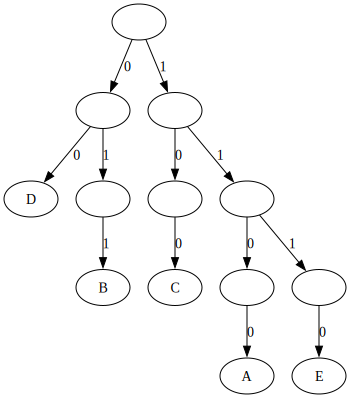

In [12]:
encoder.tree.vizualize()

In [13]:
encoder.entropy

2.121928094887362

In [14]:
encoder.expected_code_length

2.8000000000000003

## Задача II: код Хаффмана

Реализуйте код Хаффмана

In [15]:
import heapq


class BinaryAlphabet(str, Enum):
    zero: "0"
    one: "1"


@dataclass(kw_only=True)
class HuffmanNode(TreeNode[ChannelChar, SourceChar]):
    """Node in the Huffman tree during construction."""

    freq: float

    def __lt__(self, other: "HuffmanNode[ChannelChar, SourceChar]") -> bool:
        return self.freq < other.freq


class BinaryHuffmanEncoder(PrefixEncoderDecoder[SourceChar, BinaryAlphabet]):
    """
    Huffman encoder-decoder for optimal prefix codes.

    This encoder implements the Huffman coding algorithm, which constructs
    an optimal prefix code for a given set of symbol frequencies. More
    frequent symbols get shorter codes, minimizing the expected code length.

    Attributes:
        _frequencies: Dictionary mapping source symbols to their frequencies
    """

    def __init__(self, frequencies: Dict[SourceChar, float]) -> None:
        """
        Initialize the Huffman encoder with symbol frequencies.

        Args:
            frequencies: Dictionary mapping source symbols to their
                        frequencies (or probabilities)

        Raises:
            ValueError: If frequencies don't match source alphabet,
                       or if channel alphabet is not binary
        """
        self._frequencies = frequencies
        """Dictionary mapping source symbols to their frequencies."""

        super().__init__(frequencies.keys(), ["0", "1"])

    def _build_prefix_code_tree(self) -> None:
        """Build Huffman tree using the priority queue algorithm."""
        # Create leaf nodes for all symbols
        heap = []
        for symbol, freq in self._frequencies.items():
            heapq.heappush(heap, HuffmanNode(freq=freq, value=symbol))

        # Build Huffman tree
        while len(heap) > 1:
            left = heapq.heappop(heap)
            right = heapq.heappop(heap)
            parent = HuffmanNode(
                freq=left.freq + right.freq,
                value=None,
                children={"0": left, "1": right},
            )
            heapq.heappush(heap, parent)

        # Convert Huffman tree to prefix code tree
        root_huffman = heap[0] if heap else None
        self._tree = PrefixCodeTree(root_huffman)
        self._build_table_from_tree()

    def _huffman_to_prefix_tree(
        self, huffman_node: Optional[HuffmanNode]
    ) -> PrefixCodeTree[BinaryAlphabet, SourceChar]:
        """Convert Huffman tree to prefix code tree."""
        prefix_tree = PrefixCodeTree()

        def build_tree(
            current_huffman: HuffmanNode, current_prefix: List[BinaryAlphabet]
        ) -> None:
            if current_huffman.symbol is not None:
                # Leaf node: insert code
                prefix_tree.insert_code(current_prefix, current_huffman.symbol)
            else:
                # Internal node: traverse left (0) and right (1)
                if current_huffman.left:
                    build_tree(
                        current_huffman.left,
                        current_prefix + [self._channel_alphabet[0]],
                    )
                if current_huffman.right:
                    build_tree(
                        current_huffman.right,
                        current_prefix + [self._channel_alphabet[1]],
                    )

        if huffman_node:
            build_tree(huffman_node, [])

        return prefix_tree

    @property
    def expected_code_length(self) -> float:
        """
        Calculate the expected code length.

        Returns:
            Expected number of channel symbols per source symbol,
            weighted by symbol frequencies
        """
        if not self._code_table:
            return 0.0

        total = 0.0
        for symbol, freq in self._frequencies.items():
            if symbol in self._code_table:
                total += freq * len(self._code_table[symbol])
        return total

    @property
    def entropy(self) -> float:
        """
        Calculate the Shannon entropy of the source.

        Returns:
            Shannon entropy in bits (for binary channel)
        """
        h = 0.0
        for freq in self._frequencies.values():
            if freq > 0:
                h -= freq * math.log2(freq)
        return h

    @property
    def coding_efficiency(self) -> float:
        """
        Calculate the coding efficiency.

        Returns:
            Ratio of entropy to expected code length,
            representing how close the code is to optimal
        """
        expected_len = self.expected_code_length
        if expected_len == 0:
            return 0.0
        return self.entropy / expected_len

In [16]:
logger = PandasLogger()
probabilities = {"A": 0.1, "B": 0.2, "C": 0.2, "D": 0.4, "E": 0.1}

# Create encoder with binary channel alphabet
encoder = BinaryHuffmanEncoder(probabilities)

# Probabilitstic sender
sender = ProbabilisticSender(
    encoder=encoder,
    probabilities=probabilities,
    message_length_range=(1, 10),
    logger=logger,
    seed=42,
)
# Create channel
channel = NoiselessChannel(logger=logger)
# Create tracking receiver
receiver = TrackingReceiver(encoder, logger=logger)

print("Running experiment with 1000 messages...")
# Create and run experiment
runner = ExperimentRunner(sender, channel, receiver)
result = runner.run(num_messages=1000)

print("Experiment Results:")
print(f"   Duration: {result.duration:.4f} seconds")
print(f"   Total messages: {result.stats.total_messages}")
print(f"   Decoded: {result.stats.decoded_messages}")
print(f"   Messages with decoding errors: {result.stats.decode_errors}")
print(
    f"   Correctly decoded (decoded match original): {result.stats.successful_messages}"
)
print(f"   Total source symbols: {result.stats.total_source_symbols}")
print(f"   Total channel symbols: {result.stats.total_channel_symbols}")
print(f"   Average code length: {result.stats.average_code_len:.2f}")
print(f"   Avg. processing time: {result.stats.avg_message_time:.6f} s/msg")
logger.dataframe.head()

Running experiment with 1000 messages...
Experiment Results:
   Duration: 0.0277 seconds
   Total messages: 1000
   Decoded: 1000
   Messages with decoding errors: 0
   Correctly decoded (decoded match original): 1000
   Total source symbols: 5585
   Total channel symbols: 12215
   Average code length: 2.19
   Avg. processing time: 0.000015 s/msg


,timestamp,event,message_id,message_data
0,1.771323e+09,source_generated,0,AB
1,1.771323e+09,transmitted,0,10001
2,1.771323e+09,received,0,10001
3,1.771323e+09,decoded,0,AB
4,1.771323e+09,source_generated,1,BBDD


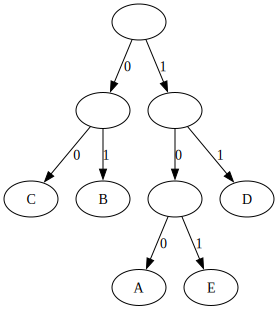

In [17]:
enc = BinaryHuffmanEncoder(probabilities)
enc.tree.vizualize()

In [18]:
encoder.entropy

2.121928094887362

In [19]:
encoder.expected_code_length

2.2